# Part 1. Data analysis

## Import data

In [15]:
import bz2, json
import pandas as pd
import tqdm
import re
import nltk

import nltk
import pymorphy3
import numpy as np
from collections import Counter

from gensim import similarities

In [2]:
path = 'banki_responses.json.bz2'

with bz2.open(path, 'rt') as bzinput:
    lines = []
    for i, cont in tqdm.tqdm(enumerate(bzinput)):
        tweets = json.loads(cont)
        lines.append(tweets)

201030it [02:04, 1612.08it/s]


In [3]:
df = pd.DataFrame(lines)
df.head(5)

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Воронеж,True,Ипотека на 5+,0,лицензия № 1623,e.novikova,ВТБ 24,2015-06-08 11:06:56,Здравствуйте! Хотелось бы выразить благодарно...,5.0
1,г. Казань,True,ЗВОНКИ СОСЕДЯМ,0,лицензия № 2289,KZN\Vorontsova_NA,Русский Стандарт,2015-06-06 18:17:52,Уважаемые представители департамента по работе...,2.0
2,г. Санкт-Петербург,True,Ложная информация!!!!,0,лицензия № 2307,Evgenia15,Союз,2015-06-07 19:08:33,Здравствуйте. Столкнулась с такой ситуацией. в...,2.0
3,г. Москва,True,Банкомат не зачислил деньги на счет,1,лицензия № 2557,dolgov.work,Ситибанк,2015-06-07 19:22:00,1 июня 2015 в Москве в отделении по адресу Смо...,1.0
4,г. Волгоград,True,Невозможно закрыть карту 2(два)!!!,0,лицензия № 3354,copLine,Ренессанс Кредит,2015-06-08 14:54:55,История очень долгая! Пришел я в банк (это раз...,1.0


## 1. Посчитайте количество отзывов в разных городах и на разные банки

In [4]:
df['city'] = df['city'].str.replace(r'г\.|пос\.|р\.п\.|д.', '', regex=True)

df['city'].nunique()

7021

In [5]:
df['bank_name'].nunique()

733

## 2. Постройте гистограмы длин ТЕКСТОВ в символах и в словах

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
func = lambda x: ' '.join(re.findall(r'\w+|\d+', x.lower()))

texts_all = df['text']
texts_words = df['text'].apply(func)

### Будем работать на очищенных текстах

In [8]:
def words_len(txt):
    return len(txt.split())

def char_len(txt):
    return len(txt)

char_len_data = texts_words.apply(char_len)
words_len_data = texts_words.apply(words_len)

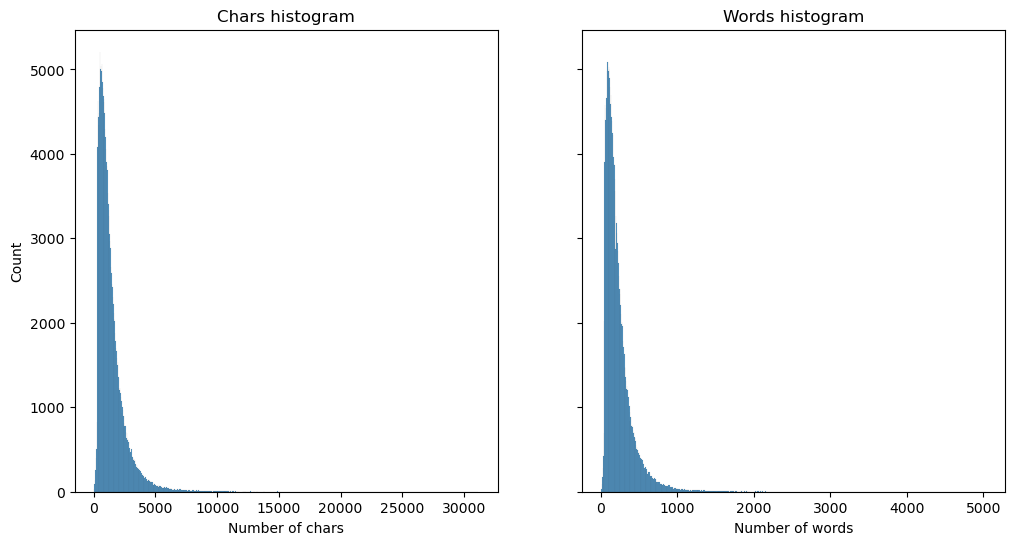

In [9]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(12, 6))

sns.histplot(ax=axes[0], data=char_len_data)
axes[0].set_title('Chars histogram')
axes[0].set_xlabel('Number of chars')
sns.histplot(ax=axes[1], data=words_len_data)
axes[1].set_title('Words histogram')
axes[1].set_xlabel('Number of words')

plt.show()

## 3. Найдите 10 самых частых:

- слов

In [10]:
all_words = list(word for i in texts_words[:10001] for word in i.split())

In [11]:
all_count = Counter(all_words)

all_count.most_common(10)

[('в', 70707),
 ('и', 58160),
 ('не', 46435),
 ('на', 38673),
 ('что', 33761),
 ('я', 31354),
 ('с', 26526),
 ('по', 21541),
 ('мне', 17649),
 ('банка', 16520)]

- слов без стоп-слов

In [12]:
check_stops = lambda x: x not in nltk.corpus.stopwords.words('russian')

words_wo_stops = list(filter(check_stops, all_words))
count_wo_stops = Counter(words_wo_stops)

count_wo_stops.most_common(10)

[('банка', 16520),
 ('банк', 13520),
 ('это', 9549),
 ('деньги', 6524),
 ('карты', 5601),
 ('карту', 5353),
 ('2015', 5326),
 ('кредит', 4778),
 ('день', 4491),
 ('банке', 4066)]

- лемм

In [18]:
morph = pymorphy3.MorphAnalyzer()

In [24]:
lemmatize = lambda x: morph.parse(x)[0].normal_form

In [25]:
all_lemmas = list(map(lemmatize, all_words))
lemm_counter = Counter(all_lemmas)

lemm_counter.most_common(10)

[('в', 71924),
 ('я', 61416),
 ('и', 58160),
 ('не', 46435),
 ('банк', 40349),
 ('на', 38673),
 ('что', 35100),
 ('с', 29954),
 ('быть', 23951),
 ('по', 21541)]

- существительных

In [26]:
is_noun = lambda x: morph.parse(x)[0].tag.POS == 'NOUN'

In [27]:
all_nouns = filter(is_noun, all_lemmas)
noun_counter = Counter(all_nouns)

noun_counter.most_common(10)

[('банк', 40349),
 ('карта', 17788),
 ('кредит', 9729),
 ('день', 9377),
 ('сотрудник', 9008),
 ('деньга', 8838),
 ('клиент', 7771),
 ('счёт', 7337),
 ('мочь', 6736),
 ('сумма', 6626)]

## 4. Постройте кривые Ципфа и Хипса

### Будем строить на лемматизированных словах

### Кривая Ципфа

- Здесь по топ-1_000 по популярности слов (для наглядности перехода)

In [28]:
for_visualization = np.array(lemm_counter.most_common(1_000))

# xs = for_visualization[:, 0]
ys = list(map(int, for_visualization[:, 1]))

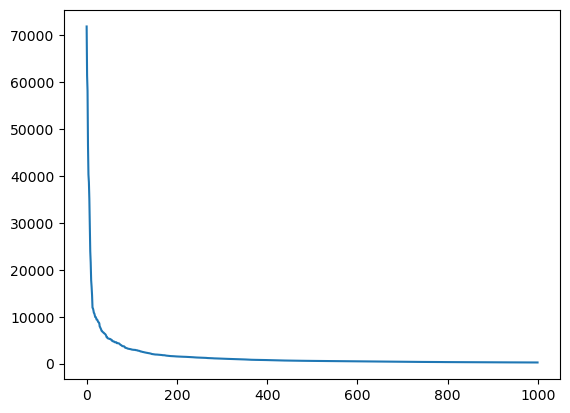

In [29]:
plt.plot(range(len(ys)),ys)

### Кривая Хипса

- Здесь по 10_000 первым комментариям

In [30]:
def get_dict_lens(texts):
    set_ = set()
    for text in texts:
        for i in text:
            set_.add(i)
        yield len(list(set_))

In [31]:
first_100_texts = texts_words[:1000].str.split()

In [32]:
ys = np.fromiter(get_dict_lens(first_100_texts), dtype=int)

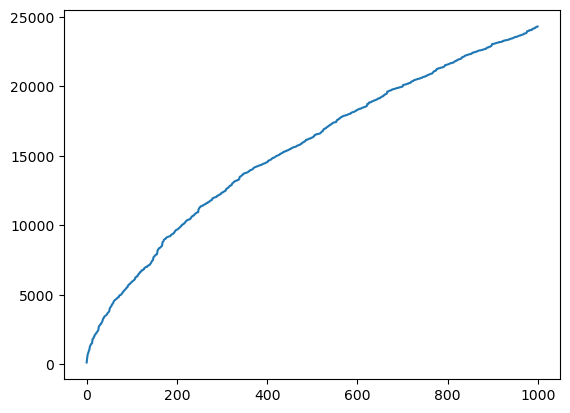

In [33]:
plt.plot(range(len(ys)), ys)

## 5. Ответьте на следующие вопросы:

- какое слово встречается чаще, "сотрудник" или "клиент"?

In [34]:
kwords_1 = ('сотрудник', 'клиент')

print(f'Чаще встречается слово "{max(kwords_1, key=lambda x: lemm_counter[x])}"\n')
for kw in kwords_1:
    print(f'Слово "{kw}" встречается {lemm_counter[kw]} раз')

Чаще встречается слово "сотрудник"

Слово "сотрудник" встречается 9008 раз
Слово "клиент" встречается 7771 раз


- сколько раз встречается слова "мошенничество" и "доверие"?

In [35]:
kwords_2 = ('мошенничество', 'доверие')

for kw in kwords_2:
    print(f'Слово "{kw}" встречается {lemm_counter[kw]} раз')

Слово "мошенничество" встречается 200 раз
Слово "доверие" встречается 154 раз


## 6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [47]:
ru_words = re.compile(r"[А-Яа-я]+")

def words_only(text):
    return ' '.join(ru_words.findall(text.lower()))

In [48]:
df['text_preprocess'] = df['text'].apply(words_only)

In [49]:
corpus_5s = df[df.rating_grade == 5]['text_preprocess']
corpus_1s = df[df.rating_grade == 1]['text_preprocess']

In [50]:
def find_key_word(n_doc, tfidf_model, tfidf_matrix):

    doc_tfidf_vals = tfidf_matrix[n_doc].toarray()[0]
    index = np.where(doc_tfidf_vals == max(doc_tfidf_vals))[0][0]
    
    kword = tfidf_model.get_feature_names_out()[index]
    return kword

def show_kwords_example(text, corpus, ngram):
    tfidf = TfidfVectorizer(ngram_range=(ngram, ngram))
    tf_matrix = tfidf.fit_transform(corpus)

    print(f'{text} for {ngram}-grams')

    for i, _ in enumerate(corpus[:5]):
        print(f'Keyword for doc# {i}:', end=' ')
        print(find_key_word(i, tfidf, tf_matrix))

- Unigrams positive reviews

In [51]:
show_kwords_example('Positive reviews', corpus_5s, 1)

Positive reviews for 1-grams
Keyword for doc# 0: выдачей
Keyword for doc# 1: дудс
Keyword for doc# 2: вузовский
Keyword for doc# 3: кредитном
Keyword for doc# 4: тула


- Unigrams negative reviews

In [52]:
show_kwords_example('Negative reviews', corpus_1s, 1)

Negative reviews for 1-grams
Keyword for doc# 0: расследование
Keyword for doc# 1: ужасно
Keyword for doc# 2: сформировалась
Keyword for doc# 3: отвечать
Keyword for doc# 4: окон


- Bigrams for positive reviews

In [53]:
show_kwords_example('Positive reviews', corpus_5s, 2)

Positive reviews for 2-grams
Keyword for doc# 0: выдачей кредита
Keyword for doc# 1: более ипотекой
Keyword for doc# 2: банку пошел
Keyword for doc# 3: вышел полученным
Keyword for doc# 4: россии тула


- Bigrams for negative reviews

In [54]:
show_kwords_example('Negative reviews', corpus_1s, 2)

Negative reviews for 2-grams
Keyword for doc# 0: расследование результате
Keyword for doc# 1: счет карты
Keyword for doc# 2: вкладку управление
Keyword for doc# 3: банк лиц
Keyword for doc# 4: оценка посещение


____